# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
pip install xgboost

     |████████████████████████████████| 166.7 MB 12 kB/s /s eta 0:00:01   |█████████████████▍              | 90.6 MB 30.1 MB/s eta 0:00:03
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install bayesian-optimization

  Created wheel for bayesian-optimization: filename=bayesian_optimization-1.2.0-py3-none-any.whl size=11685 sha256=53b5fac10b7969c0aa9b7fb60b041d480cf228eb93f474d4c52998dcb34184a5
  Stored in directory: /home/ec2-user/.cache/pip/wheels/22/cf/f4/600b7619db8e0ce75023fc14145fc432a54522b7b7b4778ecf
Successfully built bayesian-optimization
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install lightgbm

     |████████████████████████████████| 2.0 MB 34.2 MB/s eta 0:00:01
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install scikit-optimize==0.8.1

     |████████████████████████████████| 101 kB 1.8 MB/s eta 0:00:01
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install scikit-learn==0.23.2

     |████████████████████████████████| 6.8 MB 17.6 MB/s eta 0:00:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.24.1
    Uninstalling scikit-learn-0.24.1:
      Successfully uninstalled scikit-learn-0.24.1
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [6]:
# import libraries here; add more as necessary

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans

from sklearn.impute import SimpleImputer

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd


%matplotlib inline
plt.style.use('fivethirtyeight')

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).


In [7]:
# I have renamed Udacity_AZDIAS_052018.csv and Udacity_CUSTOMERS_052018.csv for more readability
# load data from csv files to make operation on them
# missing values found in section of missing values and set it here for furure use
missing_values = ["X", "XX"]
azdias = pd.read_csv('../data/azdias.csv',sep=';',na_values=missing_values)
customers = pd.read_csv('../data/customers.csv',sep=';',na_values=missing_values)



In [8]:
#I have renamed DIAS Attributes - Values 2017.xlsx to attributes
# use openpyxl as an engine for reading xlsx files
# as far as first row of attributes file is empty I set skip first row of attributes
attributes = pd.read_excel('../data/attributes.xlsx' , engine='openpyxl', skiprows = 1)

In [9]:
#there are three features in customers dataframe that is not in azdias 
# so I remove these three feature from customers dataframe
# I put axis=1 because I want to drop columns from dataframe
# I put inplace=true to make changes on customers here and does not need to save it in another variable

customers.drop(['PRODUCT_GROUP', 'CUSTOMER_GROUP', 'ONLINE_PURCHASE'], axis = 1, inplace = True)

In [10]:
#check the shape of azdias dataframe
azdias.shape

(891221, 366)

In [11]:
#check the shape of customers dataframe
customers.shape

(191652, 366)

In [12]:
#to see rows of dataframe I use head(n) that It's default value is 5

azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [13]:
#to see rows of dataframe I use head(n) that It's default value is 5

customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,3.0,5.0,3.0,2.0,6.0,9.0,7.0,3,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,6.0,6.0,3.0,0.0,9.0,NaN,3,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,4.0,10.0,13.0,11.0,6.0,9.0,2.0,3,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,6.0,4.0,2.0,NaN,9.0,7.0,1,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,3.0,5.0,4.0,2.0,9.0,3.0,1,1,3


In [14]:
#here I check all features datatype to found the ones that have object datatype
#after finding them I have to check number of those features 
#if it has fewer object datatype I have to change them to nan
# and if it has too many object datatype I have to tranform them to suitable datatype

#get list of feature with object datatype by name
list_object_feature = list(azdias.select_dtypes(include=['object']).columns)

#change list of feature to index of them
list_object_feature_index=azdias.columns.get_indexer(list_object_feature)

#list those features and number of unique elements in the object
azdias.iloc[:, list_object_feature_index].nunique()

CAMEO_DEU_2015                44
D19_LETZTER_KAUF_BRANCHE      35
EINGEFUEGT_AM               5162
OST_WEST_KZ                    2
dtype: int64

In [15]:
azdias["OST_WEST_KZ"].unique()

array([nan, 'W', 'O'], dtype=object)

OST_WEST_KZ is flag indicating the former GDR/FRG and have -1,w,o and because it has two parameter I will change it to binary 0,1

In [16]:
azdias["D19_LETZTER_KAUF_BRANCHE"].unique()

array([nan, 'D19_UNBEKANNT', 'D19_SCHUHE', 'D19_ENERGIE', 'D19_KOSMETIK',
       'D19_VOLLSORTIMENT', 'D19_SONSTIGE', 'D19_BANKEN_GROSS',
       'D19_DROGERIEARTIKEL', 'D19_HANDWERK', 'D19_BUCH_CD',
       'D19_VERSICHERUNGEN', 'D19_VERSAND_REST', 'D19_TELKO_REST',
       'D19_BANKEN_DIREKT', 'D19_BANKEN_REST', 'D19_FREIZEIT',
       'D19_LEBENSMITTEL', 'D19_HAUS_DEKO', 'D19_BEKLEIDUNG_REST',
       'D19_SAMMELARTIKEL', 'D19_TELKO_MOBILE', 'D19_REISEN',
       'D19_BEKLEIDUNG_GEH', 'D19_TECHNIK', 'D19_NAHRUNGSERGAENZUNG',
       'D19_DIGIT_SERV', 'D19_LOTTO', 'D19_RATGEBER', 'D19_TIERARTIKEL',
       'D19_KINDERARTIKEL', 'D19_BIO_OEKO', 'D19_WEIN_FEINKOST',
       'D19_GARTEN', 'D19_BILDUNG', 'D19_BANKEN_LOKAL'], dtype=object)

D19_LETZTER_KAUF_BRANCHE has too many categorical value so I will drop it later

In [17]:
azdias['CAMEO_DEU_2015'].unique()

array([nan, '8A', '4C', '2A', '6B', '8C', '4A', '2D', '1A', '1E', '9D',
       '5C', '8B', '7A', '5D', '9E', '9B', '1B', '3D', '4E', '4B', '3C',
       '5A', '7B', '9A', '6D', '6E', '2C', '7C', '9C', '7D', '5E', '1D',
       '8D', '6C', '6A', '5B', '4D', '3A', '2B', '7E', '3B', '6F', '5F',
       '1C'], dtype=object)

In [18]:
azdias['CAMEO_DEUG_2015'].unique()

array([nan,  8.,  4.,  2.,  6.,  1.,  9.,  5.,  7.,  3.])

In [19]:
azdias['CAMEO_INTL_2015'].unique()

array([nan, 51., 24., 12., 43., 54., 22., 14., 13., 15., 33., 41., 34.,
       55., 25., 23., 31., 52., 35., 45., 44., 32.])

we see all three CAMEO_DEU_2015,CAMEO_DEUG_2015 and CAMEO_INTL_2015 has X and XX value that have to change to nan because they are not correct value

I will add them to n_values at the start of project when I want to read azdias and customers datasets

EINGEFUEGT_AM has date and time I will extract year so I can mange it as numerical value

In [20]:
attributes.drop(['Unnamed: 0'], axis = 1, inplace = True)

because first column of attribute data frame is empty I will drop it

## Deal with missed values

In [21]:
#first I have to list all values that recognize as unknow
unkown_list= attributes['Meaning'].where(attributes['Meaning'].str.contains('unknown')).value_counts().index

In [22]:
# make a list that have unknown values of each attribute
unkown_attributes_list = attributes[attributes['Meaning'].isin(unkown_list)]

In [23]:
def unknown_to_nan(dataframe):
   
    # rotate through all of unkown attributes
    for row in unkown_attributes_list.iterrows():
        
        # list the missed Value attributes from attributs excel file
        missed_values_list = row[1]['Value']
        
        # list the attributes from attributs excel file
        attribute = row[1]['Attribute']

        # to pass if columns is not in dataframe
        if attribute not in dataframe.columns:
            
            continue

        # to pass if value is integer
        if isinstance(missed_values_list, int):
            
            dataframe[attribute].replace(missed_values_list, -1, inplace=True)
         # to pass if value is String    
        elif isinstance(missed_values_list, str):
            
            #parses the expression to make it as integer -1 with unkown
            eval("dataframe[attribute].replace([" + missed_values_list + "], -1, inplace=True)")
            
            dataframe[attribute].replace(missed_values_list, -1, inplace=True)

    return dataframe

In [24]:
#change all azdias unkown value to fill with -1
azdias = unknown_to_nan(azdias)

In [25]:
#change all customers unkown value to fill with -1
customers = unknown_to_nan(customers)

In [26]:
azdias_missing_columns = azdias.isnull().sum()/(len(azdias))*100

print("percent of azdias column with least number of missing value",azdias_missing_columns.min())
print("percent of azdias column with most number of missing value",azdias_missing_columns.max())

percent of azdias column with least number of missing value 0.0
percent of azdias column with most number of missing value 99.86479223447382


In [27]:
customers_missing_columns = customers.isnull().sum()/(len(customers))*100

print("percent of customers column with least number of missing value",customers_missing_columns.min())
print("percent of customers column with most number of missing value",customers_missing_columns.max())

percent of customers column with least number of missing value 0.0
percent of customers column with most number of missing value 99.87686014234133


there is not any columns that has more than 80 percent data loss except four of them that we will deal with them in next steps

In [28]:
azdias_missing_rows = azdias.isnull().sum()/(len(azdias.columns))*100

print("percent of azdias row with least number of missing value",azdias_missing_rows.min())
print("percent of azdias row with most number of missing value",azdias_missing_rows.max())

percent of azdias row with least number of missing value 0.0
percent of azdias row with most number of missing value 243173.77049180327


In [29]:
customers_missing_rows = customers.isnull().sum()/(len(customers.columns))*100

print("percent of customers row with least number of missing value",customers_missing_rows.min())
print("percent of customers row with most number of missing value",customers_missing_rows.max())

percent of customers row with least number of missing value 0.0
percent of customers row with most number of missing value 52299.453551912564


In [30]:

azdias_missing_columns = azdias.isnull().sum()/(len(azdias))

In [31]:
#list which features have missing value more than 80 percent
missing_percent=0.80
azdias[azdias_missing_columns[azdias_missing_columns > missing_percent].index]

,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4
0,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN
...,...,...,...,...
891216,NaN,NaN,NaN,NaN
891217,NaN,NaN,NaN,NaN
891218,NaN,NaN,NaN,NaN
891219,17.0,NaN,NaN,NaN


#### ALTER_KIND1,ALTER_KIND2,ALTER_KIND3 and ALTER_KIND4 are features that related to age of childern, so It's ok that some of them is null. I won't drop them

## clean dataframe and transform some features

In [32]:
#cast datatype to float
def values_type_to_float(dataframe,column):
    
    dataframe[column] = dataframe[column].astype('float')

    
    return dataframe

In [33]:
#map the value to numerical value  
def values_map(dataframe,feature_old,feature_new,dictionary):
    
    dataframe[feature_new] = dataframe.loc[:, feature_old].map(dictionary)
    
    return dataframe

In [34]:
# make feature to have just year to mange it as numerical value
def year_extractor(dataframe,column):
    
    dataframe['EINGEFUEGT_AM'] = pd.to_datetime(dataframe['EINGEFUEGT_AM']).dt.year
    
    return dataframe


In [35]:
def drop_features(dataframe,features):

    dataframe.drop(features, axis=1,inplace=True)
    
    return dataframe

In [36]:
#step by step cleaning and transforming process
def clean_transform(dataframe,dataframe_name):
    
    #dataframe= values_replace(dataframe)
    print(dataframe_name,'replace object values : done')
    
    dataframe= values_type_to_float(dataframe,'CAMEO_DEUG_2015')
    print(dataframe_name,'cast values to float : done')
    
    dataframe= values_type_to_float(dataframe,'CAMEO_INTL_2015')
    print(dataframe_name,'cast values to float : done')
    

    dataframe= values_map(dataframe,'OST_WEST_KZ','OST_WEST_KZ_E',{'W': 0, 'O': 1})
    print(dataframe_name,'OST_WEST_KZ mapping : done')

    
    dataframe= year_extractor(dataframe,'EINGEFUEGT_AM')
    print(dataframe_name,'EINGEFUEGT_AM year extraction : done')

    
    dataframe= drop_features(dataframe,['LNR', 'D19_LETZTER_KAUF_BRANCHE', 'OST_WEST_KZ', 'CAMEO_DEU_2015'])
    print(dataframe_name,'drop some features : done')

    
    dataframe= values_map(dataframe,'PRAEGENDE_JUGENDJAHRE','PRAEGENDE_JUGENDJAHRE_DECADE',{1: 1, 2: 1, 3: 2, 4: 2, 5: 3, 6: 3, 7: 3, 8: 4, 9: 4, 10: 5,11: 5, 12: 5, 13: 5, 14: 6,15: 6, 0: np.nan})
    print(dataframe_name,'PRAEGENDE_JUGENDJAHRE mapping : done')

    
    dataframe= values_map(dataframe,'PRAEGENDE_JUGENDJAHRE','PRAEGENDE_JUGENDJAHRE_MOVEMENT',{1: 0, 2: 1, 3: 0, 4: 1, 5: 0, 6: 1, 7: 1, 8: 0, 9: 1, 10: 0, 11: 1, 12: 0, 13: 1, 14: 0, 15: 1, 0: np.nan})
    print(dataframe_name,'PRAEGENDE_JUGENDJAHRE mapping : done')

    
    dataframe= drop_features(dataframe,['PRAEGENDE_JUGENDJAHRE'])
    print(dataframe_name,'drop PRAEGENDE_JUGENDJAHRE as an old feature : done')


    print(dataframe_name,'cleaning and transforming finished')
    return dataframe

In [37]:
#start the proccess of clean azdias dataframe from object datatype and transform some features to new feature
azdias = clean_transform(azdias,'azdias')


azdias replace object values : done
azdias cast values to float : done
azdias cast values to float : done
azdias OST_WEST_KZ mapping : done
azdias EINGEFUEGT_AM year extraction : done
azdias drop some features : done
azdias PRAEGENDE_JUGENDJAHRE mapping : done
azdias PRAEGENDE_JUGENDJAHRE mapping : done
azdias drop PRAEGENDE_JUGENDJAHRE as an old feature : done
azdias cleaning and transforming finished


In [38]:
#start the proccess of clean customers dataframe from object datatype and transform some features to new feature
customers = clean_transform(customers,'customers')

customers replace object values : done
customers cast values to float : done
customers cast values to float : done
customers OST_WEST_KZ mapping : done
customers EINGEFUEGT_AM year extraction : done
customers drop some features : done
customers PRAEGENDE_JUGENDJAHRE mapping : done
customers PRAEGENDE_JUGENDJAHRE mapping : done
customers drop PRAEGENDE_JUGENDJAHRE as an old feature : done
customers cleaning and transforming finished


## Part 1: Unsupervised model:

In [39]:
#create pipline for unsupervising model
# first using simpleImputer to change missing values with numerical value
# second I use to normalize dataset into the range of  [0,1]
# third step would pca to do dimensionality reduction
pip = Pipeline([  ('imputer', SimpleImputer(strategy= 'constant', fill_value = -1)),('scaler', StandardScaler()),('pca' , PCA())])




In [40]:
#apply pca and simple imputation on azdias

azdias_with_pca = pip.fit_transform(azdias)

In [41]:
#apply pca and simple imputation on customers

customers_with_pca =  pip.transform(customers)

([<matplotlib.axis.XTick at 0x7ff6d36c6ac8>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
 

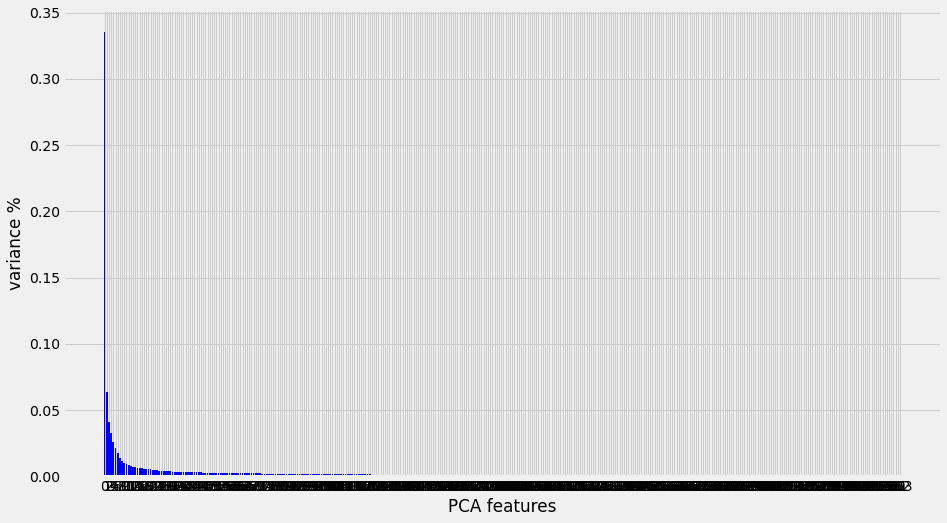

In [42]:
# Plot the explained variances to use it in clustering
fig = plt.figure(figsize = (14,8))

features = range(pip[2].n_components_)

plt.bar(features, pip[2].explained_variance_ratio_, color='blue')

plt.xlabel('PCA features')

plt.ylabel('variance %')

plt.xticks(features)

In [43]:
# 90 percent variance would be good for future works
pip[2].explained_variance_ratio_[:125].sum()

0.8934701225939429

In [44]:
# number of features that cover 90 percent variance
len(pip[2].explained_variance_ratio_)

364

In [45]:
#to find optimal number of clusters we use kmeans in this step
# our model fit with the range that we get it then we have to plot elbow and choose the number of cluster that suit our data
kmeans_range = range(2, 16)

inertias = []
for k in kmeans_range:
    
    # Create a KMeans and set init for kmeans++ and random state 42
    kmeans = KMeans(n_clusters=k,init='k-means++', random_state = 42)
    
    # Fit kmeans with sample of azdias dataframe
    kmeans.fit(azdias_with_pca[:, :125])
    
    
    inertias.append(kmeans.inertia_)
    
    print(inertias[k-2])
    

186104063.43823808
171785743.88116565
160732820.15899646
154280434.54092267
149668553.67896953
146110610.54355413
143461869.48124242
141400130.48845166
139888315.46204245
138299197.9504598
137096863.6125345
135635805.95742813
134205148.49219805
133260505.14111805


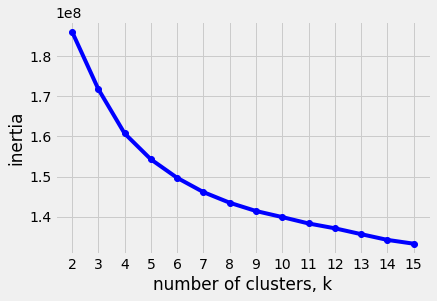

In [46]:
plt.plot(kmeans_range, inertias, '-o', color='blue')

plt.xlabel('number of clusters, k')

plt.ylabel('inertia')

plt.xticks(kmeans_range)

plt.show()

In [47]:
#here we initiate Kmeans with number of clusters that we find from elbow and Kmeans++
# so in next step we can make clustering in our azdias and customers dataframe
clusters = KMeans(n_clusters = 8,init = 'k-means++')



In [48]:
#fit cluster for azdias
azdiaz_clusters = clusters.fit(azdias_with_pca[:, :125])

In [49]:
#make a prediction clusters for our customers label
customers_clusters = clusters.predict(customers_with_pca[:, :125])

In [50]:
featues_list=azdias.columns.values.tolist()


In [51]:
type(azdiaz_clusters.labels_)
x=azdiaz_clusters.labels_

In [52]:
np.prod(azdiaz_clusters.labels_.shape)
y=customers_clusters

In [53]:
np.prod(customers_clusters.shape)

191652

In [58]:
azdias_clusters_series = pd.Series(azdiaz_clusters.labels_)

azdias_cluster_number= azdias_clusters_series.value_counts().sort_index()
azdias_cluster_number


0     32005
1    178066
2    173939
3    135101
4     73796
5    147198
6     48132
7    102984
dtype: int64

In [59]:
customers_clusters_series = pd.Series(customers_clusters)
customer_cluster_number= customers_clusters_series.value_counts().sort_index()
customer_cluster_number

0     4684
1    53740
2     1448
3    53963
4    46597
5    19632
6     6125
7     5463
dtype: int64

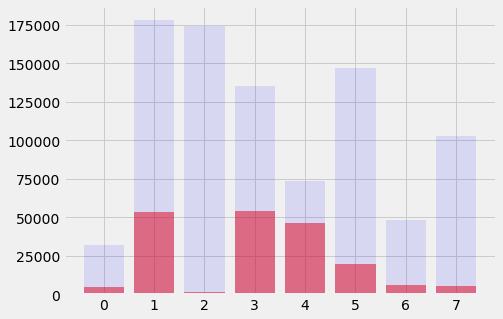

In [71]:
import matplotlib.pyplot as plt
fig = plt.figure()
Axes = fig.add_axes([0,0,1,1])

#change based on number of clusters
langs = range(8)
# make alphas deffernt to see defference between two columns of each cluster
Axes.bar(langs,customer_cluster_number,color='red',alpha=0.5)
Axes.bar(langs,azdias_cluster_number,color='blue',alpha=0.1)

plt.show()

this char show that most of customers are in clusters number 1,3,4

as far as we see most general poulation are in clusters 1,2,3,4

so between this two it's better to focus on clusters number 1 and 3
because It has more population that can be change to their customers in next step we will focus on training model that can classify our mail order for potential customers